In [6]:
# the tensorflow version of the wong/wang dynamics that only uses a TF version of the controller
#the rest is in numpy

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tf_funs import * #EKF, and helper in tensorflow
from wang_dynamics import * #the gradients for wong/wang dynamics
import sys
import pickle

tf.set_random_seed(101)
np.random.seed(101)
pi = math.pi

session_conf = tf.ConfigProto(
      intra_op_parallelism_threads=4,
      inter_op_parallelism_threads=4)
sess = tf.Session(config=session_conf)

#build graphs
xdim = 2 #state dimension
udim = 2 #control dimension
X_est = tf.placeholder(shape=(xdim),dtype=tf.float32,name='X_est') #the state estimate
PI_est = tf.placeholder(shape = (xdim,xdim),dtype=tf.float32, name = 'PI_est') #estimated covariance
Y_tp1 = tf.placeholder(shape=(xdim),dtype=tf.float32, name = 'Y_tp1') #the most recent observation
Control = tf.placeholder(shape = udim, dtype=tf.float32, name='Control')

#params for experiment
#wong dynamics
mu0 = 30. #stimulus strength. fixed in this work
coh = -6.0 #coherence of stimulus: negative coh leads to high X_1 activity 
gamma = 1e-4 #control regularization term

#koulakov dynamics
#set up analogous stimulus to koulakov line
ifact = 7.5e-4 #scaling factor, found by inspection
I_k = [0,0]
I_kbase = ifact*(1+abs(coh)/100.0);
if coh < 0:
    I_k = [-I_kbase,I_kbase]
elif coh > 0:
     I_k = [I_kbase,-I_kbase]

#define the noise for the system
dt = 1.0e-3
sigsstate = (1./dt)*5e-8 #state noise dialed in to allow transitions in koulakov dynamics
sigsobs = 1.0e-6 #default value: 

Q = sigsstate*np.eye(xdim)
Q_tf = tf.constant(Q,dtype=tf.float32, name = 'Q') #state noise covariance
R = sigsobs*np.eye(xdim)
R_tf = tf.constant(R,dtype=tf.float32, name = 'R') #observation noise covariance  

#graphs for updating state and observation
true_model_est = wonggrad(X_est,Control,mu0,coh) #state est. gradient, full myopic
true_model_est_null = wonggrad(X_est,[0.,0.],mu0,coh)#state est. gradient null control
target_model_est = koulakov_line(X_est,I_k) #state est. target dynamics

#the non-tensorflow anonymous functions, for generalizations
true_nontf = lambda x,c: wonggrad_nontf(x,c,mu0,coh)
target_nontf = lambda x: koulakov_line_nontf(x,I_k) 

X_plus,PI_plus = EKF(X_est,Y_tp1,PI_est,true_model_est,true_model_est_null,Q_tf,R_tf,xdim,dt)

#myopic controller
#graphs for controller

useMO = 1
if useMO ==1:
    print('using mean-only control')
    Cnew = myopicController_meanonly(
        X_est,PI_est,Control,gamma,true_model_est,
        true_model_est_null,target_model_est,xdim,udim)
else:
    print('using full myopic control')
    Cnew = myopicController(
        X_est,PI_est,Control,gamma,true_model_est,
        true_model_est_null,target_model_est,xdim,udim)

#covariance prediction update graph
Ak = dynamics_linearized(X_est,true_model_est_null,xdim)

#the full loss function, not just loss of mean values
loss_tf = loss_full(X_est,PI_est,true_model_est,target_model_est)


using mean-only control


In [10]:
#begin specifics of the simulation
T = 1000 #number of steps
ns = 1 #number of samples

#make the numpy version of noise
statenoise = np.random.normal(0,sigsstate**0.5,[xdim,T,ns])
obsnoise = np.random.normal(0,sigsobs**0.5,[xdim,T,ns])
G = dt**(0.5)*np.eye(xdim) #system noise matrix, for covariance prediction

#vectors of interest
x_estvec = np.zeros((xdim,T,ns)) #state estimate
x_ucvec = np.zeros((xdim,T,ns)) #uncontrolled state
xvec = np.zeros((xdim,T,ns)) #actual controlled state
yvec = np.zeros((xdim,T,ns)) #observations related to state
x_targvec = np.zeros((xdim,T,ns)) #target state
PI_estvec = np.zeros((xdim,xdim,T,ns)) #estimated covariance
contall = np.zeros((udim,T,ns)) #control

#loss function values in vector form as
#(full loss, mean-only loss, jacobian loss term, Hessian term)
loss = np.zeros((4,T,ns))
loss_nocont = np.zeros((4,T,ns))
loss_true = np.zeros((T,ns))
initvals = np.zeros((xdim,ns))

lag = 1 #1+number of steps difference between observations and state estimate

init = tf.global_variables_initializer()

for m in range(ns):
    sess.run(init)
    x_init = np.random.uniform(0.1,0.2,(2,))
    initvals[:,m] = x_init
    PI_init = [[1.0e-6,0.],[0.,1.0e-6]] #initial covariance
    c_init = [0.,0.]

    xest_k = x_init
    pi_k = PI_init
    c_k = c_init
    x_k = x_init
    x_targ_k = x_init
    ykp1 = np.array(x_init)

    x_estvec[:,0,m] = x_init
    xvec[:,0,m] = x_init
    x_ucvec[:,0,m] = x_init
    x_targvec[:,0,m] = x_init
    PI_estvec[:,:,0,m] = PI_init
    
    #go ahead and propagate lag-steps ahead before starting state estimation and such
    for k in range(1,lag):
        #update actual dynamics
        grad_cont = true_nontf(xvec[:,k-1,m],c_init)
        grad_targ = target_nontf(x_targvec[:,k-1,m])
        grad_uc = true_nontf(x_ucvec[:,k-1,m],c_init)

        xvec[:,k,m] = xvec[:,k-1,m] + grad_cont + statenoise[:,k,m]
        x_ucvec[:,k,m] = x_ucvec[:,k-1,m] + grad_uc + statenoise[:,k,m]
        x_targvec[:,k,m] = x_targvec[:,k-1,m] + grad_targ + statenoise[:,k,m]
        yvec[:,k,m] = xvec[:,k,m] + obsnoise[:,k,m]

        #set estimates in beginning lags to initial state
        x_estvec[:,k,m] = x_init
        PI_estvec[:,:,k,m] = PI_init
    for k in range(max(1,lag),T): 
        #update actual dynamics
        grad_cont = true_nontf(xvec[:,k-1,m],contall[:,k-1,m])
        grad_uc = true_nontf(x_ucvec[:,k-1,m],c_init)
        grad_targ = target_nontf(x_targvec[:,k-1,m])
        xvec[:,k,m] = xvec[:,k-1,m] + grad_cont + statenoise[:,k,m]
        x_ucvec[:,k,m] = x_ucvec[:,k-1,m] + grad_uc + statenoise[:,k,m]
        x_targvec[:,k,m] = x_targvec[:,k-1,m] + grad_targ + statenoise[:,k,m]
        yvec[:,k,m] = xvec[:,k,m] + obsnoise[:,k,m]

        #run state estimator to update estimate of state k-lag
        test = sess.run([X_plus,PI_plus],
                        {X_est:x_estvec[:,k-lag,m], 
                         PI_est:PI_estvec[:,:,k-lag,m], 
                         Control:contall[:,k-lag,m],Y_tp1:yvec[:,k-lag+1,m]})
        x_estvec[:,k-lag+1,m] = test[0]
        PI_estvec[:,:,k-lag+1,m] = test[1]
        
        #predit lag states in the future to calculate control
        x_est_n = x_estvec[:,k-lag+1,m]
        PI_est_n = PI_estvec[:,:,k-lag+1,m]
        
        for n in range(1,lag):
            #state prediction step
            grad_cont = true_nontf(x_est_n,contall[:,k-lag-n,m])

            #covariance prediction step. calculate jacobian
            Ak_n= sess.run(Ak,
                        {X_est: x_est_n, PI_est: PI_est_n,
                         Control: contall[:,0,m], Y_tp1:yvec[:,0,m]})

            x_est_n = x_est_n + grad_cont
            PI_est_n = np.matmul(Ak_n,PI_est_n) + np.matmul(PI_est_n,np.transpose(Ak_n)) + np.matmul(
                np.matmul(G,Q),np.transpose(G))

        #run myopic controller using predicted state estimated. cov, doesnt matter
        #find control for time k
        c_k = sess.run(Cnew,{X_est:x_est_n, PI_est:PI_est_n,
                             Control:contall[:,k-1,m], Y_tp1:yvec[:,k,m]})
        #do quick comparison for jumps in control due to a singularity in dynamics

        if abs(np.linalg.norm(c_k)) > 100.:
            contall[:,k,m] = contall[:,k-1,m]
            print('dynamics likely got singular. hold tight')
            print(k)
        else:
             contall[:,k,m] = c_k
        
        #calcualte loss functions
        #true loss from actual state
        loss_true[k-lag+1,m] = np.linalg.norm(true_nontf(xvec[:,k-lag+1,m],contall[:,k-lag+1,m])-
        target_nontf(xvec[:,k-lag+1,m]))**2
        
        #approximated loss from estimated state
        ltest = sess.run(loss_tf,{X_est:x_estvec[:,k-lag+1,m],
                                               PI_est:PI_estvec[:,:,k-lag+1,m],
                                               Control:contall[:,k-lag+1,m]
                                              })
        loss[:,k-lag+1,m] = ltest
        
        #approximated loss from estimated state, no control
        ltest = sess.run(loss_tf,{X_est:x_estvec[:,k-lag+1,m],
                                               PI_est:PI_estvec[:,:,k-lag+1,m],
                                               Control:np.array([0.,0.])
                                              })
        loss_nocont[:,k-lag+1,m] = ltest
        
        
    #set final lag estimate values to esimate
    for k in range(lag-1):
        x_targvec[:,T-lag+1+k,m] = x_targvec[:,T-lag,m]
        x_estvec[:,T-lag+1+k,m] = x_estvec[:,T-lag,m]
        x_ucvec[:,T-lag+1+k,m] = x_ucvec[:,T-lag,m]
        PI_estvec[:,:,T-lag+1+k,m] = PI_estvec[:,:,T-lag,m]

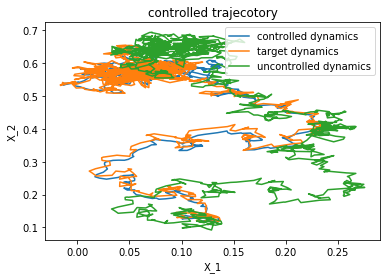

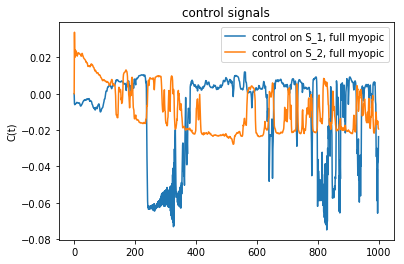

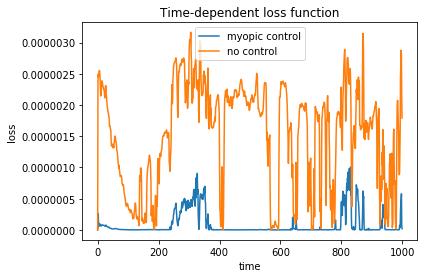

In [11]:
#true state
tind = 0
plt.plot(x_estvec[0,:,tind],x_estvec[1,:,tind],label='controlled dynamics')
plt.plot(x_targvec[0,:,tind],x_targvec[1,:,tind],label = 'target dynamics')
plt.plot(x_ucvec[0,:,tind],x_ucvec[1,:,tind],label = 'uncontrolled dynamics')
plt.legend()
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.title('controlled trajecotory')
plt.show()

plt.plot(contall[0,:,tind],label='control on S_1, full myopic')
plt.plot(contall[1,:,tind],label='control on S_2, full myopic')
plt.ylabel('C(t)')
plt.title('control signals')
plt.legend()
plt.show()

#expected state
fullloss = plt.plot(loss[0,:,tind],label='myopic control')
nocontloss = plt.plot(loss_nocont[0,:,tind],label='no control')

plt.xlabel('time')
plt.ylabel('loss')
plt.title('Time-dependent loss function')
plt.legend()
plt.show()
